# Processing, curation, and filtering of data collected by Abhinav from Bergey's manual volumen 4 (Multiple phyla).

### Preparation

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gmean
from Bio import Entrez
import time
import re
from bs4 import BeautifulSoup
import requests

In [2]:
# Interactive matplotlib plot
%matplotlib notebook

### Data tables

In [3]:
df = pd.read_csv('BMvol4.csv', sep = ',')
df.shape

(438, 8)

### Processing

Drop entries without `shape`

In [4]:
df = df.dropna(subset = ['Shape'])
df.shape

(408, 8)

Drop entries without `length` and `width`

In [5]:
df = df.dropna(subset = ['Length', 'Width'], how = 'all')
df.shape

(401, 8)

Drop entries of subspecies

In [6]:
df = df[df['Subspecies'] != 'Yes'].copy()
df.shape

(385, 8)

### Check by shape

In [7]:
df['Shape'].value_counts()

spherical    173
helical      120
rod           61
oval          10
filament       7
flask          5
fusiform       4
concave        1
spheroid       1
tear-drop      1
spindle        1
spiral         1
Name: Shape, dtype: int64

Make sure that `spherical` shapes have `length` and `width`.

In [8]:
tmp = df[df['Shape'].str.contains('spher')]

In [9]:
tmp[tmp['Width'].isnull()].shape

(0, 8)

In [10]:
tmp[tmp['Length'].isnull()].shape

(0, 8)

Drop entries without `length` or `width`

In [11]:
df = df.dropna(subset = ['Length', 'Width'], how = 'any')
df.shape

(373, 8)

## Standardize length and width values:

- For ranges (e.g., 4-8), take geometric mean
- For minimum / maximum values, take boundary.
- There are some exceptions. The following code deals with exceptions.

In [12]:
def size_to_num(size):
    """
    Function that converts a size string into a float number.
    Inputs:
        size: str contining the size
    Outputs:
        s: float containing the standardized size
    """
    #print(size)
    if '-' in size:
        if len(size.split('-')) == 2:
            return np.sqrt(np.prod([float(x) for x in size.split('-')]))
        elif len(size.split('-')) > 2:
            return gmean([float(x) for x in size.split('-')])
    elif size.startswith(('>', '<')):
        return float(size[1:])
    else:
        return float(size)

In [13]:
df['length'] = df['Length'].astype(str).apply(size_to_num)

In [14]:
df['width'] = df['Width'].astype(str).apply(size_to_num)

Make sure that length is greater than width

In [15]:
df[['length', 'width']] = df[['length', 'width']].apply(
    lambda x: pd.Series([max(x), min(x)]), axis = 1)

Drop entries with `name` not latinate

In [16]:
df['len'] = df['Name'].map(lambda x: len(x.split()))
df.shape

(373, 11)

In [17]:
df[df['len'] != 2]

,Name,Date Modified,Shape,Length,Width,Diameter,Subspecies,File #,length,width,len
55,spherical,07/04/2022,helical,5-250,0.2-0.75,NaN,No,9,35.355339,0.387298,1
142,Leptospira genomospecies 1,07/05/2022,rod,6-12,0.1,NaN,No,9,8.485281,0.100000,3
143,Leptospira genomospecies 3,07/05/2022,rod,6-12,0.1,NaN,No,9,8.485281,0.100000,3
144,Leptospira genomospecies 4,07/05/2022,rod,6-12,0.1,NaN,No,9,8.485281,0.100000,3
145,Leptospira genomospecies 5,07/05/2022,rod,6-12,0.1,NaN,No,9,8.485281,0.100000,3
404,Candidatus Xiphinematobacter brevicolli,07/11/2022,rod,2.1-3.2,0.7-1.0,NaN,No,16,2.592296,0.836660,3
405,Candidatus Xiphinematobacter americani,07/11/2022,rod,2.1-3.2,0.7-1.0,NaN,No,16,2.592296,0.836660,3
406,Candidatus Xiphinematobacter rivesi,07/11/2022,rod,2.1-3.2,0.7-1.0,NaN,No,16,2.592296,0.836660,3


In [18]:
df.drop([55, 143, 144, 145], inplace = True)
df.at[142, 'Name'] = 'Leptospira genomospecies'

## Check if organisms are already present in Bacdive

In [19]:
dataset = pd.read_table('annot/species.tsv', index_col = 0)
dataset.shape

(4875, 12)

Check if present in dataset (so far...)

In [20]:
df['Name'].astype(str).isin(dataset['species']).value_counts()

False    346
True      23
Name: Name, dtype: int64

In [21]:
df['in_dataset'] = df['Name'].astype(str).isin(dataset['species'])

In [22]:
dataset[dataset['species'] == 'Spirochaeta plicatilis']

,length,width,volume,surface,shape,species,genus,family,order,class,phylum,superkingdom
taxid,,,,,,,,,,,,


**Drop entries already present in dataset (so far...)**

In [23]:
df = df[df['in_dataset'] == False].copy()
df.shape

(346, 12)

Drop useless columns

In [24]:
df.drop(['Date Modified', 'Diameter', 'Subspecies', 'File #', 'Length', 
         'Width', 'len', 'in_dataset'], axis = 1, inplace = True)

Rename columns

In [25]:
df.rename({'Name': 'name', 'Shape': 'shape'}, axis = 1, inplace = True)

In [26]:
df.shape

(346, 4)

## Data distribution

<IPython.core.display.Javascript object>


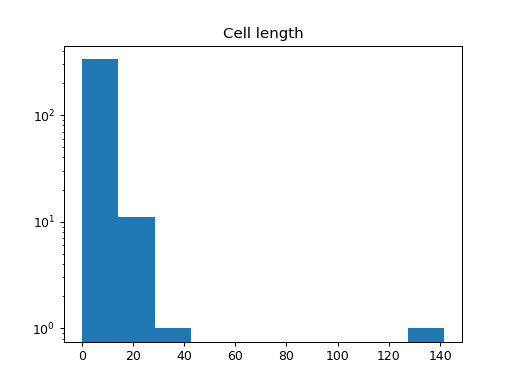

In [27]:
plt.figure()
plt.hist(df['length'], log = True)
plt.title('Cell length')
plt.show()

<IPython.core.display.Javascript object>


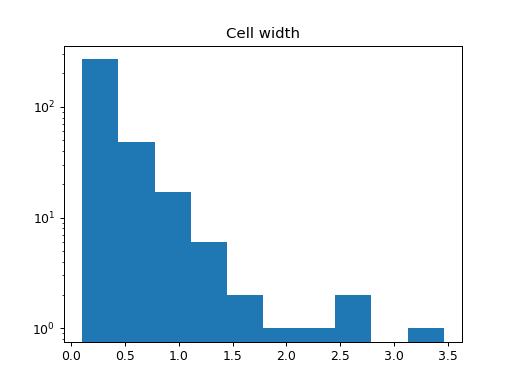

In [28]:
plt.figure()
plt.hist(df['width'], log = True)
plt.title('Cell width')
plt.show()

## Cell volume and surface area

Second, assume that cells are [capsules](https://en.wikipedia.org/wiki/Capsule_(geometry)).

- Volume: $ V = \pi r^{2} (\frac{4}{3} r + a)$

- Surface area: $ S = 2 \pi r (2r + a) $

In which $a$ = length - width, $r$ = width / 2.

In [29]:
df['volume'] = np.pi * (df['width'] / 2) ** 2 * ((4 / 3) * (df['width'] / 2) + (df['length'] - df['width']))

In [30]:
df['surface'] = 2 * np.pi * (df['width'] / 2) * (2 * (df['width'] / 2) + (df['length'] - df['width']))

In [31]:
# Set a new index
df.set_index(np.arange(0, df.shape[0]), inplace = True)

<IPython.core.display.Javascript object>


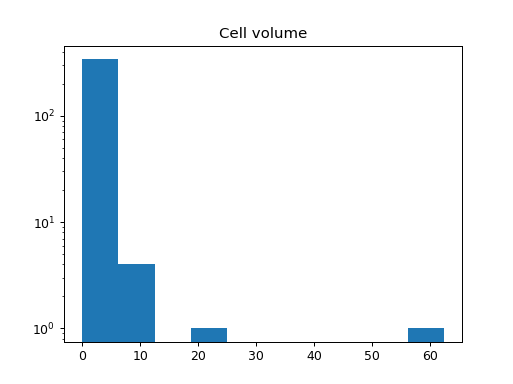

In [32]:
plt.figure()
plt.hist(df['volume'], log = True)
plt.title('Cell volume')
plt.show()

<IPython.core.display.Javascript object>


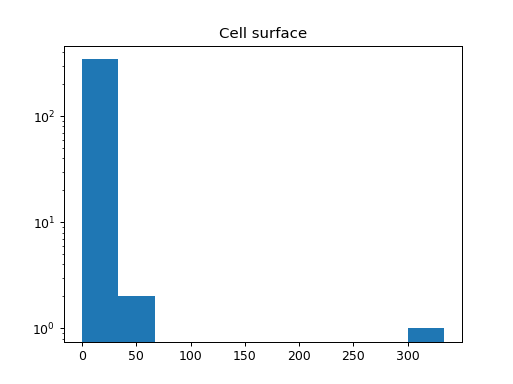

In [33]:
plt.figure()
plt.hist(df['surface'], log = True)
plt.title('Cell surface')
plt.show()

<IPython.core.display.Javascript object>


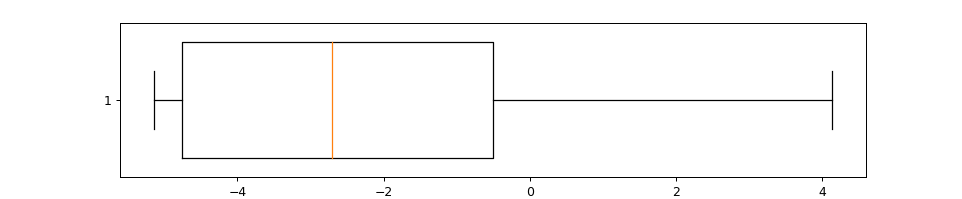

In [34]:
plt.figure(figsize = (12, 2.5))
plt.boxplot(df['volume'].apply(np.log), widths = 0.75, vert = False)
plt.show()

<IPython.core.display.Javascript object>


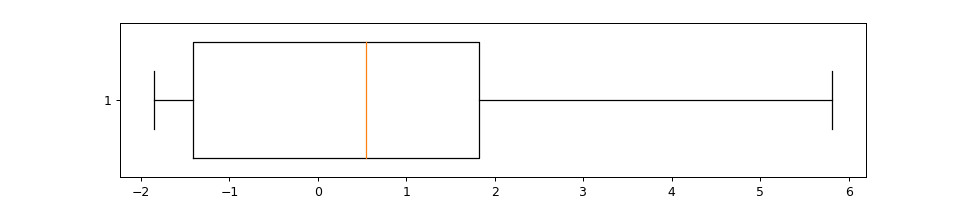

In [35]:
plt.figure(figsize = (12, 2.5))
plt.boxplot(df['surface'].apply(np.log), widths = 0.75, vert = False)
plt.show()

## Output

In [36]:
df.shape

(346, 6)

In [37]:
df.to_csv('data_BMvol4.tsv', sep = '\t')